# Image classification using convolutional neural networks

## Introduction - the dataset

Image classification has historically been one of the most challenging tasks in computer vision.
Convolutional neural networks (CNN) have allowed an unprecedented improvement in the accuracy of image classification.

For this workshop we will use a modified version of the [ISIC 2020 Challenge dataset](https://challenge2020.isic-archive.com/). The original version of this dataset contains 33126 images benign and malignant skin lesions from over 2000 patients. The dataset is particularly challenging to work with (well, it's from a challenge, after all!) because of the very imbalanced training dataset, which contains only less than 600 images of malignant lesions.

To simplify matters, and allow you to run this in a reasonable time frame, I have created a balanced version of the dataset, with 584 benign and 584 malignant images. Images in the original dataset are quite large (some are up to 4000 x 6000 pixels) and of different size; for simplicity I have resized them to 500 x 500 which should be sufficient for this workshop.

Finally, note that all of the images used in this workshop come from the training set of the challenge. This is so that we have the ground truth for each image (which is obviously unavailable for the test set in the original data).

## Learning objectives

At the end of this workshop you should be able to

- Create a CNN classifier using Keras
- Use regularization to avoid overfitting
- Use data augmentation to avoid overfitting and improve accuracy

We start by importing our _usual_ libraries, such as keras, matplotlib numpy and pandas.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow.keras as keras

The `ISIC2020_Small_metadata.csv` file contains information about all the images in the dataset. Let's open it and see what we find.

Use the `value_counts` function to count the number of images in each class (benign vs malignant). 

How many are coming from men and how many from women?

<details>
<summary style="cursor: pointer;">Click here to reveal a hint.</summary>
Try using

<code>
metadata['column_name'].value_counts()
</code>

You can even pass a list of columns instead of a single string!
</details>

In [5]:
image_dir = '/content/drive/MyDrive/ISIC2020/ISIC2020_Small/'
metadata = pd.read_csv('/content/drive/MyDrive/ISIC2020/ISIC2020_Small_metadata.csv')
print(metadata.head())

print(metadata['benign_malignant'].value_counts())
print(metadata['sex'].value_counts())
print(metadata[['sex', 'benign_malignant']].value_counts())


     image_name  patient_id   lesion_id  ... diagnosis  benign_malignant target
0  ISIC_2988993  IP_1705144  IL_8255250  ...     nevus            benign      0
1  ISIC_6498256  IP_7104534  IL_3276458  ...   unknown            benign      0
2  ISIC_8526513  IP_0892152  IL_6379048  ...   unknown            benign      0
3  ISIC_3111722  IP_8663649  IL_1170755  ...   unknown            benign      0
4  ISIC_3624807  IP_8330575  IL_3683690  ...   unknown            benign      0

[5 rows x 9 columns]
malignant    584
benign       584
Name: benign_malignant, dtype: int64
male      662
female    506
Name: sex, dtype: int64
sex     benign_malignant
male    malignant           364
        benign              298
female  benign              286
        malignant           220
dtype: int64


Because this is a very small dataset, it will easily fit into memory, so we could read all images.

This can quickly become unmanageable for larger datasets, though, but luckily Keras has a built-in function to help with this.

We are going to use the [tf.keras.preprocessing.image_dataset_from_directory](https://keras.io/api/preprocessing/image/) function to create an image generator that will pull images when needed.

The function can infer labels directly from the subdirectory names, which makes life a lot easier!

We can also provide a batch size, which is the number of images we want to load at once. We can set it to 64, which should be easy enough to handle, but you might want to experiment with that.

In [6]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

training_dataset = image_dataset_from_directory(
    image_dir, 
    labels="inferred",   
    batch_size = 64,
    subset='training',
    validation_split=0.2,
    seed=12345)

test_dataset = image_dataset_from_directory(
    image_dir,
    labels="inferred",
    batch_size = 64,
    subset='validation',
    validation_split=0.2,
    seed=12345) 

Found 1168 files belonging to 2 classes.
Using 935 files for training.
Found 1168 files belonging to 2 classes.
Using 233 files for validation.


We can now use the `take` method of the generator to load some images for display.
We can pass 1 to `take` to get a single batch of images, then iterate through them.

Note that, conveniently, `get` returns both the images and their labels.

So, you can do

`images, labels = training_dataset.take(1)`
You can then take a specific image from the batch by indexing it with `images[0]` and its label with `labels[0]`. 

Note that you can do `images[0].numpy().astype('uint8')` to get a numpy array of the image.

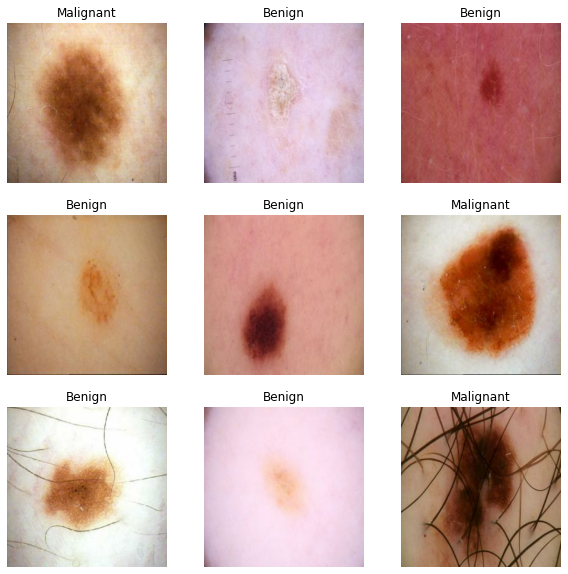

In [9]:
# Display the first 9 images
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 10)) 

classes = ['Benign', 'Malignant']

for images, labels in training_dataset.take(1):    
    for i in range(9):
        a = ax.ravel()[i]
        a.imshow(images[i].numpy().astype(np.uint8))
        a.set_title(classes[int(labels[i])])
        a.axis("off")

Ok, we have our images and labels. Let's create a model!

Create a convolutional neural network (CNN) model with the following architecture:

- 3 modules of 3x3 convolutional layers with 32, 64, and 128 filters respectively followed by a max pooling layer
- 2 dense layers with 512 and 64 units respectively
- a final dense layer with 1 unit for the output

Use ReLU activation for all layers except the last one where you can use a sigmoid.

Compile the model. 

**What optimizer and loss function do you want to use?**
**What metrics do you want to calculate?**

We will use the Adam optimizer (but you can experiment with others!) and the binary crossentropy loss function, since we are trying to classify between two classes. Note that we could use the categorical crossentropy loss function, but we would need a final dense layer with 2 nodes and a softmax activation.

Since this is a binary classification problem, we will use the accuracy metric.

In [12]:
model = keras.models.Sequential()

model.add(keras.layers.InputLayer(input_shape=(256, 256, 3)))

model.add(keras.layers.Conv2D(filters = 32, 
          kernel_size=3, 
          padding="same", 
          activation = "relu"))

model.add(keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(keras.layers.Conv2D(filters = 64, 
          kernel_size=(3,3), 
          padding="same", 
          activation = "relu"))

model.add(keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(keras.layers.Conv2D(filters = 128, 
          kernel_size=(3,3),
          padding="same", 
          activation = "relu"))

model.add(keras.layers.MaxPool2D(pool_size=(2,2)))

# Flatten the nodes and add a fully connected network at the end
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units = 512, activation = "relu"))
model.add(keras.layers.Dense(units = 64, activation = "relu"))
# Finally, we have only one node as we are doing a binary prediction
model.add(keras.layers.Dense(units = 1, activation = "sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 128)     

We can now proceed to train our model. We will train for 50 epochs, with a batch size of 128. 

So, every epoch all of the training images are used to train the network, 128 images at a time.

Note that we use our test set for validation, so we have no proper validation set for this example.

The `train` function returns the model's history, which contains information about the accuracy over training. This is important to check how well the model is working.

Since this is a fairly time-consuming process, you might want to run this on Google Colab, using a GPU.

In [ ]:
batch_size = 128
epochs_num = 50
# THIS TAKES A VERY LONG TIME
# USE THE NEXT CELL TO LOAD the pre-trained model
res = model.fit(training_dataset, 
                validation_data=test_dataset, 
                batch_size = batch_size, 
                epochs = epochs_num, 
                verbose = 1) 

# Optionally, you can save the model for later use
# model.save("mymodels/melanoma_model_01")
# You can load back the model at any time using
# model = keras.models.load_model('mymodels/melanoma_model_01)

We can now plot loss and accuracy for our model.

**What can you tell from the plot?** (you might want to zoom in on the y axis)

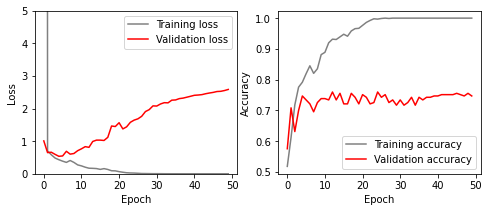

In [40]:
_, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 3))

ax[0].plot(history['loss'], c='gray', label = "Training loss")
ax[0].plot(history['val_loss'], c='red', label = "Validation loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_ylim(0, 5)
ax[0].legend()

ax[1].plot(history['accuracy'], c='gray', label="Training accuracy")
ax[1].plot(history['val_accuracy'], c='red', label = "Validation accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

We have slightly more than 75% accuracy, which is OK, but can definitely be improved!

Importantly, our model seems to be **overfitting**! 

**How do we tell that?**

1. The loss continues to decrease, but validation loss goes up
2. Training accuracy goes up, but validation reaches a plateau

There are several things that we can improve.

1. We can regularize the model by adding **dropout**. This would be especially important for the dense layers.

2. We can add regularization (e.g. **L2 regularization**) to the model

3. Part of the issue is that the training set is somewhat limited. This is partly because I have given you a only amount of a  of images, however keep in mind that having a very large amount of image data is not always a given, actually it is quite uncommon! 
As we saw in the lectures, we can use **data augmentation** to increase the size of our dataset.

Let's train a new model exactly in the same way, but adding dropout and regularization.

1. Add 40% Dropout layers after each Dense layer (not the last one, obviously!)
2. Add L2 regularization to the Conv2D layers

In [35]:
model2 = keras.models.Sequential()

model2.add(keras.layers.InputLayer(input_shape=(256, 256, 3)))

model2.add(keras.layers.Conv2D(filters = 32, 
          kernel_size=3, 
          padding="same", 
          activation = "relu",
          kernel_regularizer="l2"))

model2.add(keras.layers.MaxPool2D(pool_size=(2,2)))

model2.add(keras.layers.Conv2D(filters = 64, 
          kernel_size=(3,3), 
          padding="same", 
          activation = "relu",
          kernel_regularizer="l2"))

model2.add(keras.layers.MaxPool2D(pool_size=(2,2)))

model2.add(keras.layers.Conv2D(filters = 128, 
          kernel_size=(3,3),
          padding="same", 
          activation = "relu",
          kernel_regularizer="l2"))

model2.add(keras.layers.MaxPool2D(pool_size=(2,2)))

# Flatten the nodes and add a fully connected network at the end
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(units = 512, activation = "relu", kernel_regularizer="l2"))
model2.add(keras.layers.Dropout(0.4))
model2.add(keras.layers.Dense(units = 64, activation = "relu", kernel_regularizer="l2"))
model2.add(keras.layers.Dropout(0.4))
# Finally, we have only one node as we are doing a binary prediction
model2.add(keras.layers.Dense(units = 1, activation = "sigmoid"))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model2.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 128)     

As before, repeat the training

In [36]:
batch_size = 128
epochs_num = 50

res2 = model2.fit(training_dataset, 
                validation_data=test_dataset, 
                batch_size = batch_size, 
                epochs = epochs_num, 
                verbose = 1) 

# Save model
model2.save("/content/drive/MyDrive/ISIC2020/melanoma_02")
# Save history
np.save('/content/drive/MyDrive/ISIC2020/melanoma_02_history.npy', res2.history)

Epoch 1/50
15/15 [==============================] - 8s 366ms/step - loss: 132.8969 - accuracy: 0.5337 - val_loss: 13.7508 - val_accuracy: 0.5923
Epoch 2/50
15/15 [==============================] - 6s 349ms/step - loss: 14.5191 - accuracy: 0.5733 - val_loss: 14.9276 - val_accuracy: 0.5451
Epoch 3/50
15/15 [==============================] - 6s 346ms/step - loss: 14.6955 - accuracy: 0.5807 - val_loss: 14.3015 - val_accuracy: 0.6137
Epoch 4/50
15/15 [==============================] - 6s 354ms/step - loss: 13.9139 - accuracy: 0.5872 - val_loss: 13.4445 - val_accuracy: 0.5622
Epoch 5/50
15/15 [==============================] - 6s 345ms/step - loss: 13.0827 - accuracy: 0.5861 - val_loss: 12.6263 - val_accuracy: 0.6094
Epoch 6/50
15/15 [==============================] - 6s 348ms/step - loss: 12.2921 - accuracy: 0.6118 - val_loss: 11.9012 - val_accuracy: 0.5365
Epoch 7/50
15/15 [==============================] - 6s 344ms/step - loss: 11.5646 - accuracy: 0.6385 - val_loss: 11.1891 - val_accuracy

Plot the loss and accuracy for the regularised model

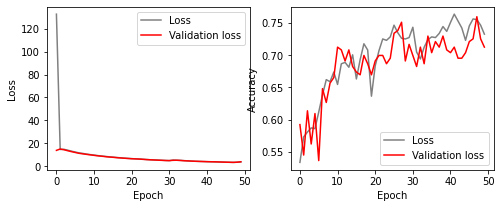

In [39]:
_, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 3))

ax[0].plot(history2['loss'], c='gray', label = "Loss")
ax[0].plot(history2['val_loss'], c='red', label = "Validation loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(history2['accuracy'], c='gray', label="Loss")
ax[1].plot(history2['val_accuracy'], c='red', label = "Validation loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

Now, that's much better!

The model is now regularised, so it does not overfit anymore. 

And that is the end of worshop 6! Hope you enjoyed it and keep learning!